<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/Final_Results/ALL_PARAMS_INCEPTION_SRCNN_FINAL_CROPPED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

train_dir = "/content/drive/MyDrive/Final_Cropped/Train"
test_dir = "/content/drive/MyDrive/Final_Cropped/Test"

# List all image paths and corresponding labels
image_paths = []
labels = []

for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)

    if not os.path.isdir(class_path):
        continue

    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_dir)  # Use the directory name as the label

# Split into train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.25, stratify=labels, random_state=40
)


In [4]:
unique_labels = set(labels)
unique_labels
import pandas as pd

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# Create DataFrame for training data
train_df = pd.DataFrame({
    "filepath": train_paths,
    "class": train_labels
})

# Create DataFrame for validation data
val_df = pd.DataFrame({
    "filepath": val_paths,
    "class": val_labels
})



val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),  # Image size for InceptionV3
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 793 validated image filenames belonging to 3 classes.
Found 264 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 332s 13s/step - accuracy: 0.4316 - loss: 18.0766 - val_accuracy: 0.8182 - val_loss: 0.4733
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 360s 12s/step - accuracy: 0.8510 - loss: 0.4120 - val_accuracy: 0.8068 - val_loss: 0.5455
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 296s 12s/step - accuracy: 0.8609 - loss: 0.3681 - val_accuracy: 0.8977 - val_loss: 0.2792
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 300s 12s/step - accuracy: 0.9072 - loss: 0.2203 - val_accuracy: 0.9167 - val_loss: 0.2116
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 296s 12s/step - accuracy: 0.9148 - loss: 0.2250 - val_accuracy: 0.8826 - val_loss: 0.4051


In [11]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 376s 14s/step - accuracy: 0.8326 - loss: 0.5343 - val_accuracy: 0.7538 - val_loss: 2.0005
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 344s 13s/step - accuracy: 0.9682 - loss: 0.0950 - val_accuracy: 0.8977 - val_loss: 0.6107
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 339s 13s/step - accuracy: 0.9678 - loss: 0.0831 - val_accuracy: 0.9394 - val_loss: 0.2855
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 377s 13s/step - accuracy: 0.9719 - loss: 0.0612 - val_accuracy: 0.9659 - val_loss: 0.2105
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 355s 14s/step - accuracy: 0.9743 - loss: 0.0660 - val_accuracy: 0.9508 - val_loss: 0.1781
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 350s 14s/step - accuracy: 0.9783 - loss: 0.0634 - val_accuracy: 0.9659 - val_loss: 0.1620
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 369s 13s/step - accuracy: 0.9905 - loss: 0.0307 - val_accuracy: 0.9697 - val_loss: 0.2272
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 335s 13s/step - accuracy: 0.9791 - loss: 0.0483 - val_accuracy: 0.

In [14]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 128 images belonging to 3 classes.


In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - accuracy: 0.9583 - loss: 0.2389
Test Accuracy: 0.9062


4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step


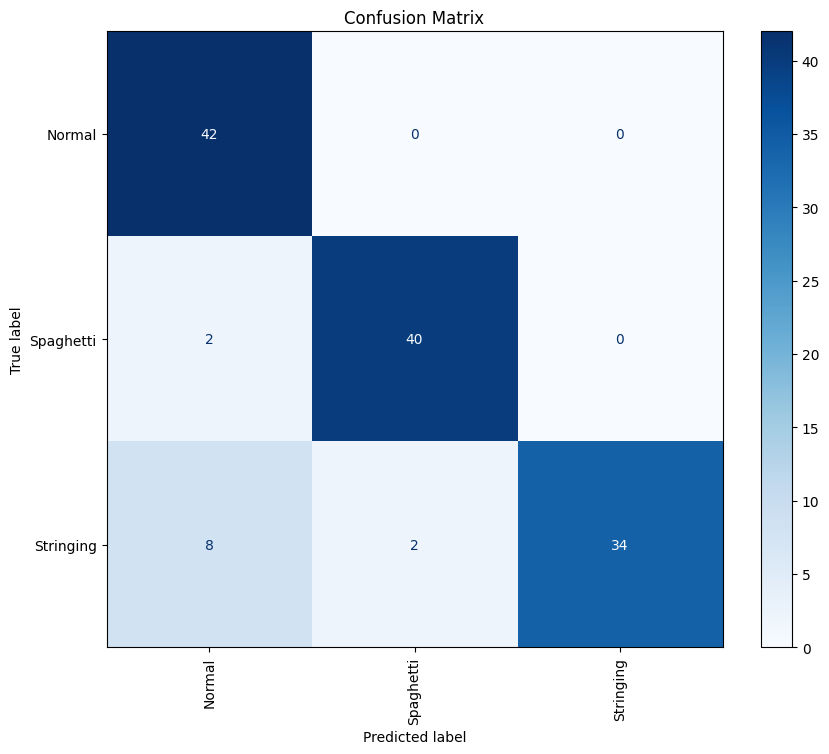

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = test_generator.classes  # These are the true labels
class_labels = list(test_generator.class_indices.keys())  # Class names

pred_probabilities = model.predict(test_generator)

predicted_labels = np.argmax(pred_probabilities, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.9062
Sensitivity (Recall): 0.9062
Specificity: 0.9531
Precision: 0.9213
F1 Score: 0.9054
Matthews Correlation Coefficient (MCC): 0.8676
Cohen's Kappa: 0.8596
90.62%
90.62%
95.31%
92.13%
90.54%
0.8676
0.8596


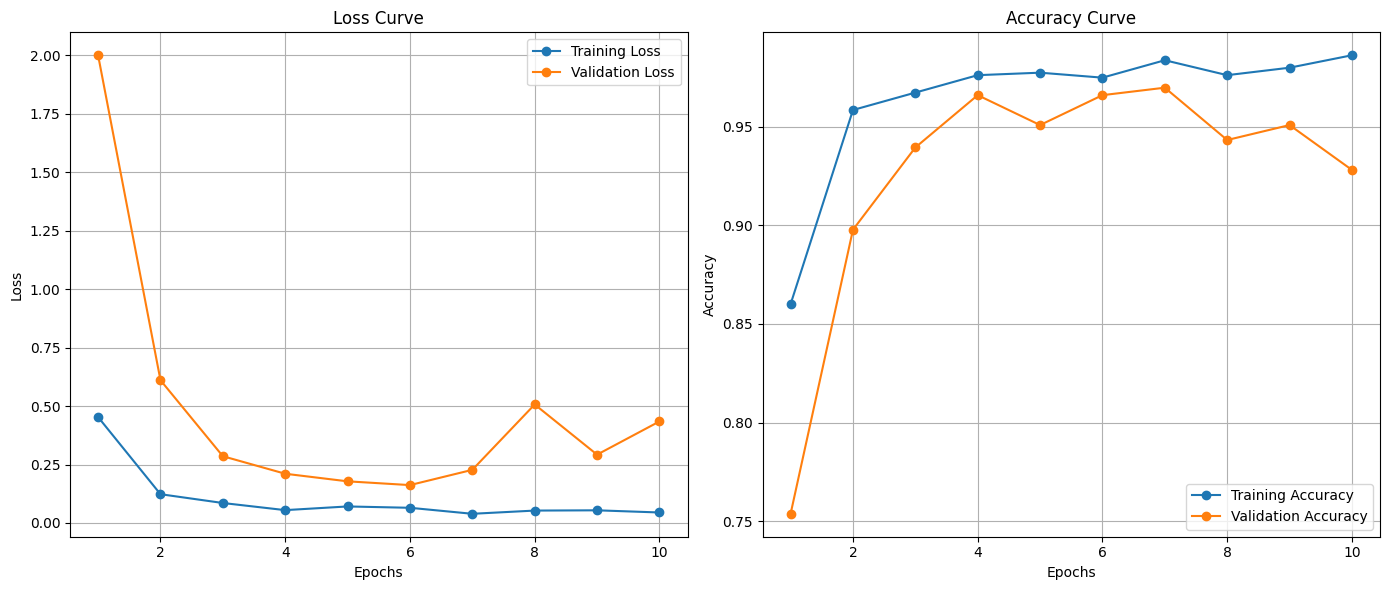

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, cohen_kappa_score
)

# Assuming 'true_labels' and 'predicted_labels' are already available
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP = np.diag(cm)  # Diagonal values are the True Positives
FP = cm.sum(axis=0) - TP  # Column sum minus TP
FN = cm.sum(axis=1) - TP  # Row sum minus TP
TN = cm.sum() - (TP + FP + FN)  # Total sum minus TP, FP, FN

# Compute Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
sensitivity = TP.sum() / (TP.sum() + FN.sum())  # Recall for all classes
specificity = TN.sum() / (TN.sum() + FP.sum())
precision = precision_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
mcc = matthews_corrcoef(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# To Copy easily
print(f"{accuracy * 100:.2f}%")
print(f"{sensitivity * 100:.2f}%")
print(f"{specificity * 100:.2f}%")
print(f"{precision * 100:.2f}%")
print(f"{f1 * 100:.2f}%")
print(f"{mcc:.4f}")
print(f"{kappa:.4f}")

# Plot Validation Loss and Accuracy Curves
history_fine_dict = history_fine.history  # Extract history object
val_loss = history_fine_dict['val_loss']
val_accuracy = history_fine_dict['val_accuracy']
loss = history_fine_dict['loss']
accuracy = history_fine_dict['accuracy']
epochs = range(1, len(val_loss) + 1)

# Plot Loss Curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
